
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Классификация изображений</b></h3>

In [29]:
import torch
import PIL

from torchvision.transforms import v2
from sklearn.metrics import f1_score
import pandas as pd
import gc
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path


from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os

In [2]:
torch.cuda.ipc_collect()  # собирает неиспользуемые блоки
gc.collect()
torch.cuda.empty_cache()

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

## My CNN

### Dataset

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=10),
            #v2.RandomGrayscale(p=0.1),
            v2.RandomPerspective(distortion_scale=0.3, p=0.2),
            v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            v2.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
            v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('data/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('data/journey-springfield/testset/testset')

In [7]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

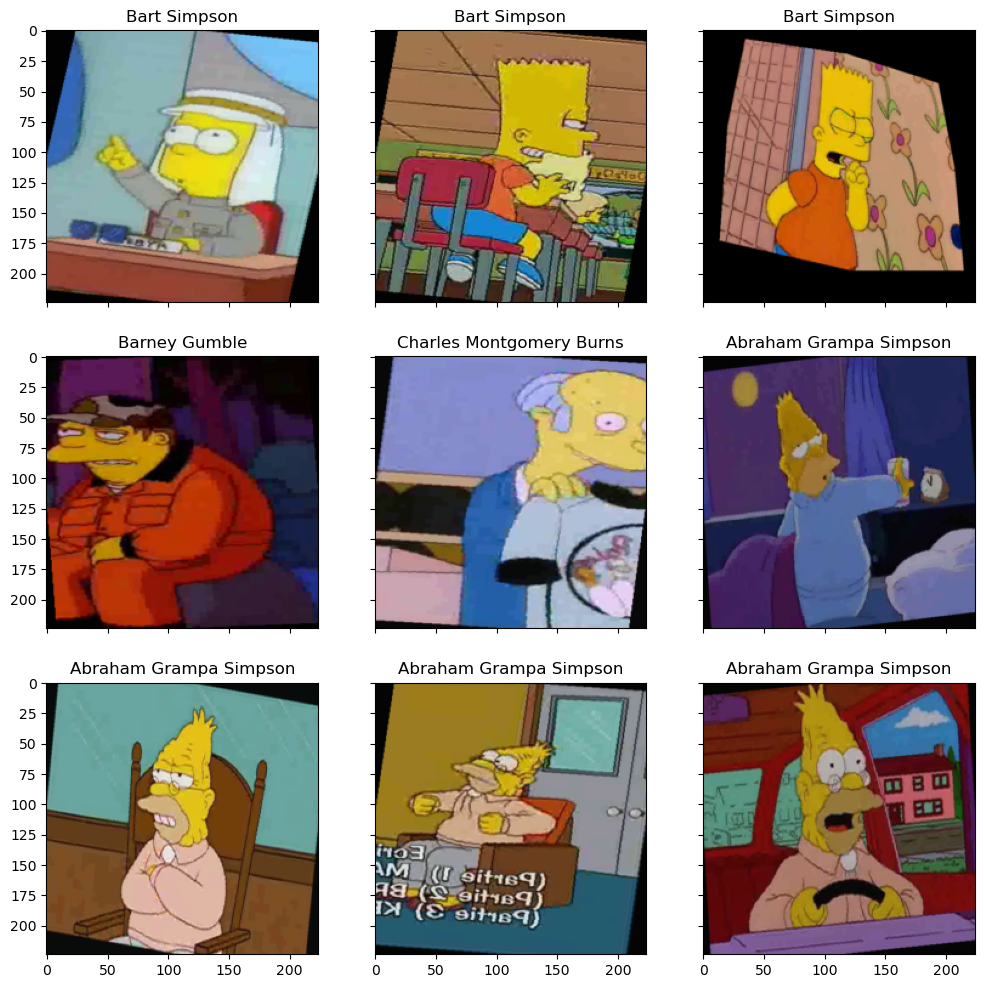

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
plt.show()

### Model

In [11]:
class MyCNN(nn.Module):
    """
    Параметры:
    ----------
    n_classes : int
        Количество классов для классификации.

    Примечание:
    ----------
    Входные изображения должны иметь размерность (3, H, W), где
    3 - слои rgb для цветной картинки, а H и W - высота и ширина изображения,
    соответственно. Размер выходного тензора будет равен (n_classes).

    Методы:
    -------
    forward(x):
        Пропускает входные данные через сеть и возвращает логиты для
        каждого класса.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1), # 8 * 224 * 224
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2) # 8 * 112 * 112
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1, stride=1, padding=0), # 16 * 112 * 112
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # 32 * 112 * 112
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=2), # 64 * 116 * 116
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.skip_1_4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=1, stride=1, padding=2),  # 112 → 116
            nn.BatchNorm2d(64)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0), # 128 * 58 * 58
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=2, padding=0), # 256 * 29 * 29
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=1, padding=0), # 512 * 29 * 29
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        self.skip_4_7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=512, kernel_size=4, stride=4, padding=0),  # 116 → 29
            nn.BatchNorm2d(512),
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=2, padding=0), # 1024 * 14 * 14
            nn.ReLU(),
            nn.BatchNorm2d(1024)
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=2, stride=2, padding=0), # 256 * 7 * 7
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1, padding=0), # 128 * 7 * 7
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.skip_7_10 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=2, stride=1, padding=0),  # 29 → 7
            nn.BatchNorm2d(128),
            nn.AvgPool2d(kernel_size=4) # 128 * 7 * 7
        )
        
        self.linear1 = nn.Sequential(
            nn.Linear(in_features=128 * 7 * 7, out_features=512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.35)
        )
        self.linear2 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.35)
        )
        self.out = nn.Linear(in_features=128, out_features=n_classes)


    def forward(self, x):
        out1 = self.conv1(x)

        x = self.conv2(out1)
        x = self.conv3(x)

        out4 = self.conv4(x)
        out4 = self.skip_1_4(out1) + out4

        x = self.conv5(out4)
        x = self.conv6(x)

        out7 = self.conv7(x)
        out7 = self.skip_4_7(out4) + out7

        x = self.conv8(out7)
        x = self.conv9(x)

        out10 = self.conv10(x)
        out10 = self.skip_7_10(out7) + out10
        
        x = out10.view(out10.size(0), -1)

        x = self.linear1(x)
        x = self.linear2(x)
        logits = self.out(x)
        return logits

### Код обучения

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Функция обучает модель на одной эпохе, используя предоставленный dataloader.

    Эта функция проходит по всем данным в `train_loader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    train_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток. Должен возвращать кортежи (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели на основе
        градиентов, вычисленных в процессе обучения.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий средний лосс (train_loss) и точность (train_acc)
        на обучающем наборе данных за текущую эпоху.
    """

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    """
    Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

    Эта функция проходит по всем данным в `val_loader`, выполняет прямое
    распространение, вычисляет лосс и точность модели. В конце эпохи
    возвращаются средний лосс и точность на валидационном наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо оценить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    val_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток для валидации. Должен возвращать кортежи
        (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий среднюю потерю (val_loss) и точность (val_acc)
        на валидационном наборе данных за текущую эпоху.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [22]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_files : list
        Список файлов или путей к файлам, содержащим обучающие данные.

    val_files : list
        Список файлов или путей к файлам, содержащим валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        #scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            #scheduler.step()
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            torch.save(model.state_dict(), f'My_CNN_{epoch}_epoch.pt')

    return history

In [18]:
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Обучение модели

In [23]:
n_classes = len(np.unique(train_val_labels))
my_cnn = MyCNN(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(my_cnn)

we will classify :42
MyCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (skip_1_4): Sequential(
    (0): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 

In [24]:
history = train(train_dataset, val_dataset, model=my_cnn, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.257709227425937


epoch:  10%|█         | 1/10 [03:40<33:06, 220.74s/it]


Epoch 001 train_loss: 2.2577     val_loss 1.6619 train_acc 0.3991 val_acc 0.5552
loss 1.4115615411430145


epoch:  20%|██        | 2/10 [07:06<28:14, 211.84s/it]


Epoch 002 train_loss: 1.4116     val_loss 1.2211 train_acc 0.6117 val_acc 0.6626
loss 0.9949399953329211


epoch:  30%|███       | 3/10 [10:21<23:50, 204.36s/it]


Epoch 003 train_loss: 0.9949     val_loss 0.9548 train_acc 0.7169 val_acc 0.7394
loss 0.796599317632729


epoch:  40%|████      | 4/10 [13:38<20:08, 201.43s/it]


Epoch 004 train_loss: 0.7966     val_loss 0.9147 train_acc 0.7721 val_acc 0.7511
loss 0.6050766461160852


epoch:  50%|█████     | 5/10 [17:06<16:57, 203.53s/it]


Epoch 005 train_loss: 0.6051     val_loss 0.7711 train_acc 0.8244 val_acc 0.7929
loss 0.49579935741429115


epoch:  60%|██████    | 6/10 [20:35<13:41, 205.39s/it]


Epoch 006 train_loss: 0.4958     val_loss 0.7717 train_acc 0.8564 val_acc 0.7948
loss 0.407819601215901


epoch:  70%|███████   | 7/10 [23:56<10:12, 204.02s/it]


Epoch 007 train_loss: 0.4078     val_loss 0.8326 train_acc 0.8806 val_acc 0.7954
loss 0.35703037183534125


epoch:  80%|████████  | 8/10 [27:14<06:44, 202.23s/it]


Epoch 008 train_loss: 0.3570     val_loss 0.8005 train_acc 0.8918 val_acc 0.8089
loss 0.31087247258964273


epoch:  90%|█████████ | 9/10 [30:23<03:18, 198.14s/it]


Epoch 009 train_loss: 0.3109     val_loss 0.7576 train_acc 0.9053 val_acc 0.8231
loss 0.28949093835749773


epoch: 100%|██████████| 10/10 [33:33<00:00, 201.39s/it]


Epoch 010 train_loss: 0.2895     val_loss 0.7101 train_acc 0.9108 val_acc 0.8387


In [25]:
loss, acc, val_loss, val_acc = zip(*history)

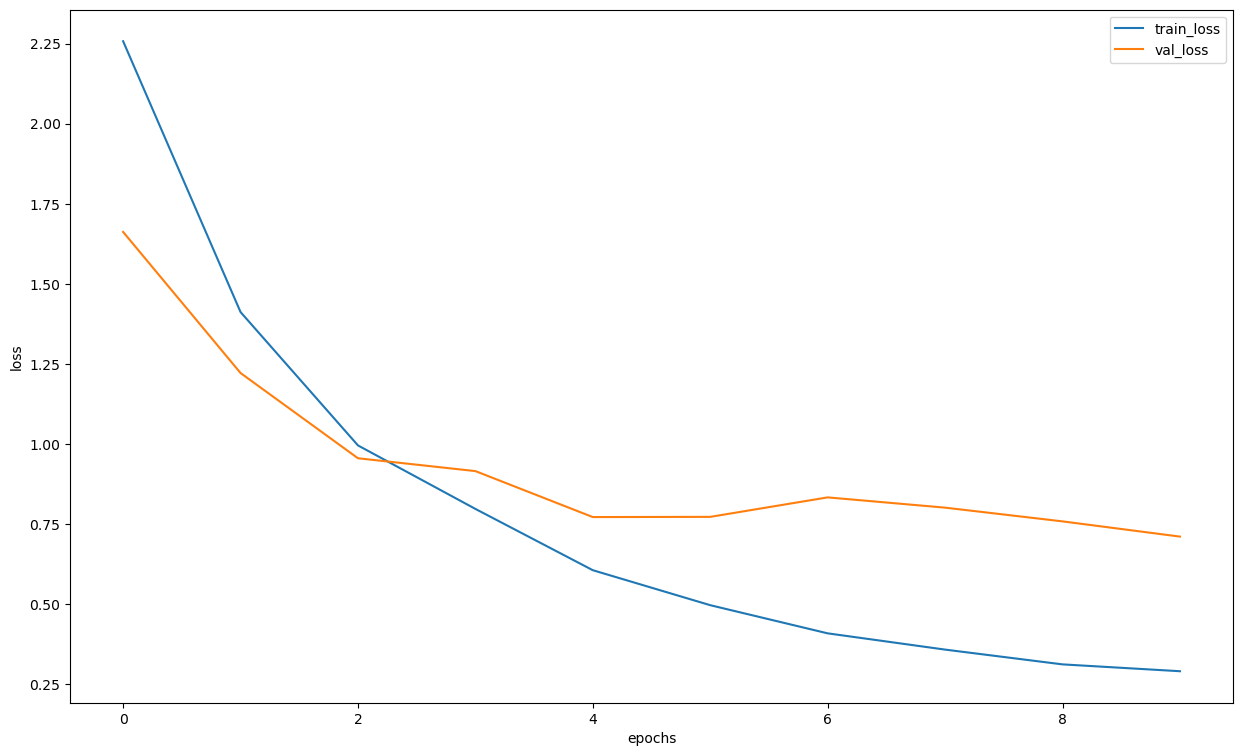

In [35]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Предсказание результата

In [26]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_cnn, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_cnn, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [27]:
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.75


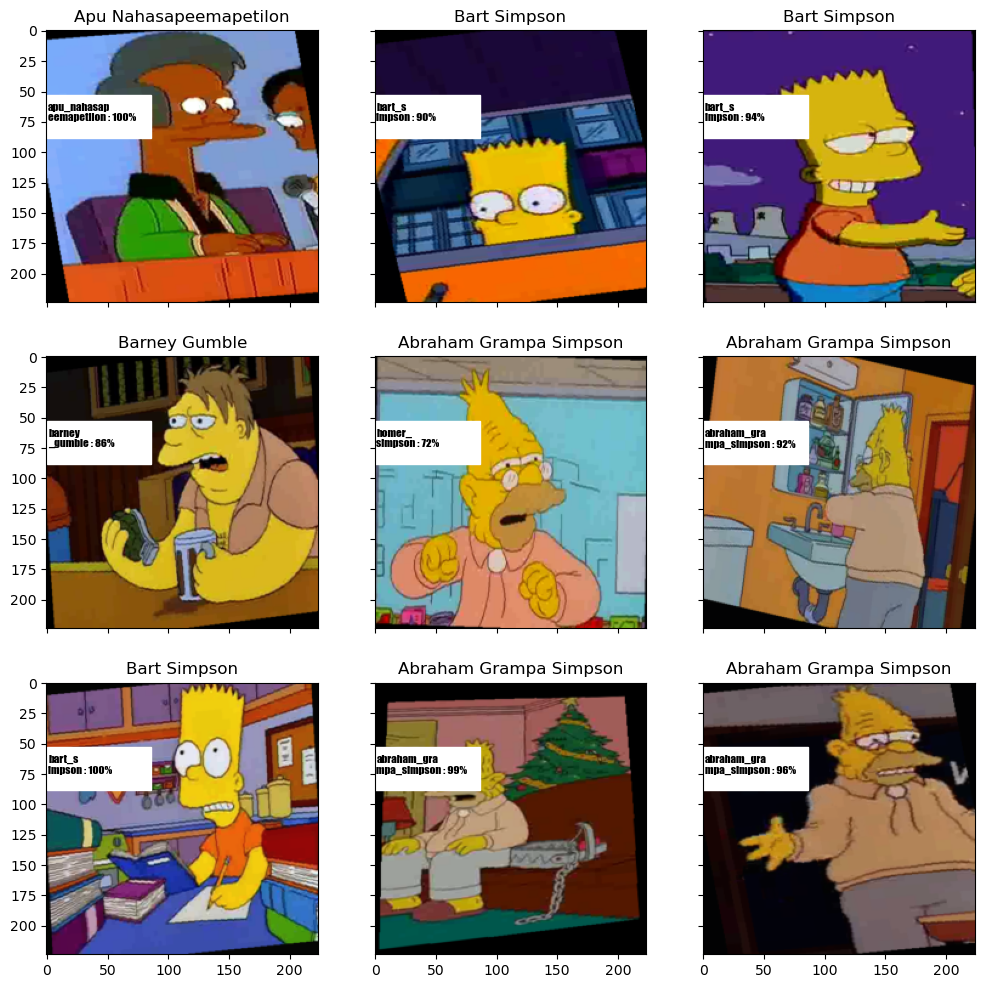

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(my_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

plt.show()

### Kaggle

In [32]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(my_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.read_csv("data/journey-springfield/sample_submission.csv")

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

my_submit.to_csv('my_cnn.csv', index=False)

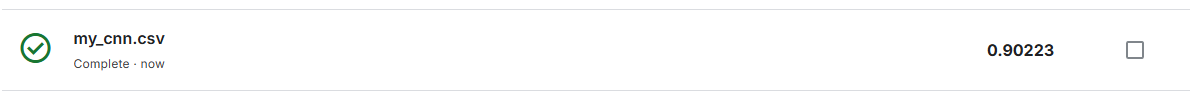

## Resnet50

### Код обучения

In [44]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_files : list
        Список файлов или путей к файлам, содержащим обучающие данные.

    val_files : list
        Список файлов или путей к файлам, содержащим валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            torch.save(model.state_dict(), f'Resnet50_{epoch}_epoch.pt')

    return history

### Модель

In [36]:
models.resnet50(pretrained=True)

c:\Users\mserg\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mserg\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\mserg/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 10.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [45]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 42)

parameters_to_train = []

parameters_to_train += list(model.fc.parameters())

if hasattr(model, 'layer4'):
    for param in model.layer4.parameters():
        param.requires_grad = True
        parameters_to_train.append(param)

c:\Users\mserg\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mserg\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
torch.cuda.empty_cache()
resnet50_model = model.to(DEVICE)

In [47]:
history = train(train_dataset, val_dataset, resnet50_model, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.6523920376233686


epoch:  10%|█         | 1/10 [03:15<29:16, 195.16s/it]


Epoch 001 train_loss: 0.6524     val_loss 0.4125 train_acc 0.8427 val_acc 0.8915
loss 1.2832520465762292


epoch:  20%|██        | 2/10 [06:31<26:06, 195.85s/it]


Epoch 002 train_loss: 1.2833     val_loss 0.6244 train_acc 0.6637 val_acc 0.8435
loss 0.399384636629599


epoch:  30%|███       | 3/10 [09:48<22:53, 196.23s/it]


Epoch 003 train_loss: 0.3994     val_loss 0.3817 train_acc 0.8983 val_acc 0.9049
loss 0.19782599027794373


epoch:  40%|████      | 4/10 [13:03<19:36, 196.03s/it]


Epoch 004 train_loss: 0.1978     val_loss 0.2394 train_acc 0.9462 val_acc 0.9362
loss 0.1654282991894036


epoch:  50%|█████     | 5/10 [16:24<16:28, 197.75s/it]


Epoch 005 train_loss: 0.1654     val_loss 0.2222 train_acc 0.9541 val_acc 0.9434
loss 0.13729093548002286


epoch:  60%|██████    | 6/10 [19:47<13:17, 199.33s/it]


Epoch 006 train_loss: 0.1373     val_loss 0.2149 train_acc 0.9625 val_acc 0.9436
loss 0.12072608348842837


epoch:  70%|███████   | 7/10 [23:06<09:58, 199.46s/it]


Epoch 007 train_loss: 0.1207     val_loss 0.2029 train_acc 0.9682 val_acc 0.9513
loss 0.11949531574812397


epoch:  80%|████████  | 8/10 [26:27<06:39, 199.78s/it]


Epoch 008 train_loss: 0.1195     val_loss 0.1964 train_acc 0.9691 val_acc 0.9511
loss 0.11703391715336532


epoch:  90%|█████████ | 9/10 [29:54<03:22, 202.03s/it]


Epoch 009 train_loss: 0.1170     val_loss 0.2081 train_acc 0.9703 val_acc 0.9496
loss 0.11592357030066117


epoch: 100%|██████████| 10/10 [33:13<00:00, 199.39s/it]


Epoch 010 train_loss: 0.1159     val_loss 0.2047 train_acc 0.9692 val_acc 0.9499


In [52]:
best_resnet50 = resnet50_model

best_resnet50.load_state_dict(torch.load('Resnet50_7_epoch.pt'))

<All keys matched successfully>

### Предсказание результата

In [53]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(best_resnet50, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(best_resnet50, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [54]:
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


### Kaggle

In [55]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(best_resnet50, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.read_csv("data/journey-springfield/sample_submission.csv")

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

my_submit.to_csv('best_resnet50.csv', index=False)

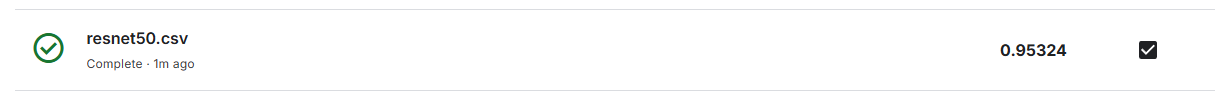